# **Importing Libraries**

In [21]:
# Install missing packages
#%pip install pandas seaborn statsmodels scikit-learn


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#import linear model
from sklearn.linear_model import LinearRegression

#import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# **Import Data**

In [22]:
# setting the file path - locally.
file_path = './data_store_sales/'
# Load the merged files into pandas DataFrames
df_train= pd.read_csv(file_path+'merged_dataset.csv')

In [4]:
# reading the merged dataset
df_train.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,is_event
0,24,105574,2013-01-02,18790.0,12.0,0,0,93.140000,2605,0,0
1,24,105574,2013-01-03,59692.0,1.0,0,0,92.970000,2462,0,0
2,24,105574,2013-01-04,99664.0,3.0,0,0,93.120000,2607,0,0
3,24,105574,2013-01-05,140805.0,4.0,0,0,93.146667,2578,0,0
4,24,105574,2013-01-06,182800.0,7.0,0,0,93.173333,2061,0,0


In [4]:
df_train_2013_01_02 = df_train[(df_train['store_nbr'] == 24) & (df_train['date'] == '2013-01-02')]
df_train_2013_01_02.head(7)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,is_event
0,24,105574,2013-01-02,18790.0,12.0,0,0,93.14,2605,0,0
1687,24,105575,2013-01-02,18791.0,2.0,0,0,93.14,2605,0,0
3374,24,105577,2013-01-02,18792.0,1.0,0,0,93.14,2605,0,0
5061,24,105693,2013-01-02,18793.0,7.0,0,0,93.14,2605,0,0
6748,24,105737,2013-01-02,18794.0,17.0,0,0,93.14,2605,0,0
8435,24,105857,2013-01-02,18795.0,1.0,0,0,93.14,2605,0,0
10122,24,106716,2013-01-02,18796.0,3.0,0,0,93.14,2605,0,0


In [3]:
df_train = df_train.drop(columns=['id'])
df_train.shape

(35069356, 10)

In [23]:
df_train.isnull().sum()

store_nbr              0
item_nbr               0
date                   0
id              20323588
unit_sales             0
onpromotion            0
outlier                0
dcoilwtico             0
transactions           0
is_holiday             0
is_event               0
dtype: int64

# **Feature Engineering**   

## **1.Time Based Features (from date)**

In [7]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['dayofweek'] = df_train['date'].dt.dayofweek        # 0 = Monday
df_train['is_weekend'] = df_train['dayofweek'].isin([5, 6]).astype(int)
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['weekofyear'] = df_train['date'].dt.isocalendar().week
df_train['year'] = df_train['date'].dt.year
df_train['is_month_start'] = df_train['date'].dt.is_month_start.astype(int)
df_train['is_month_end'] = df_train['date'].dt.is_month_end.astype(int)

In [8]:
print(df_train['is_month_start'].value_counts())
print(df_train['is_month_end'].value_counts())

is_month_start
0    33926016
1     1143340
Name: count, dtype: int64
is_month_end
0    33926016
1     1143340
Name: count, dtype: int64


## **2.Lag Features (based on past values)**

### Seasonal Decomposition

/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_20104/1123992455.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_sales = daily_sales.fillna(method='ffill')


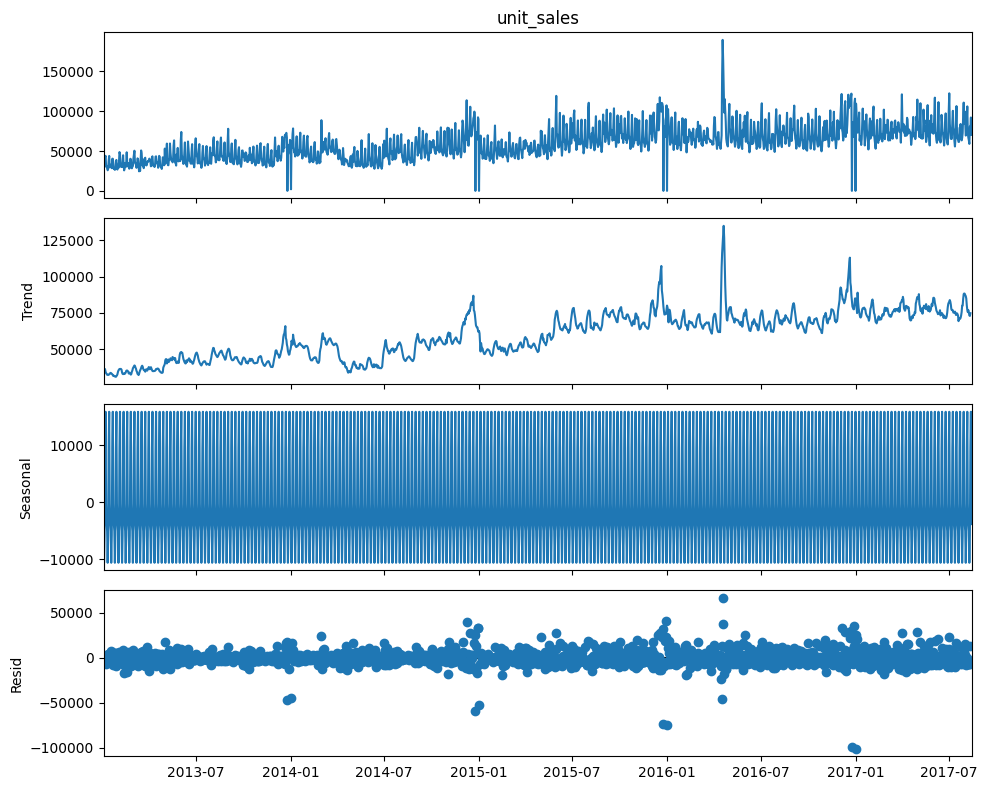

In [9]:
# seasonal decomposition the df_train
# Make sure the  data is sorted and indexed properly
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.sort_values('date')

# Optional: aggregate if data is per item/store
daily_sales = df_train.groupby('date')['unit_sales'].sum()

# Set date as index
daily_sales = daily_sales.asfreq('D')  # Ensure a daily frequency

# Fill missing days if any
daily_sales = daily_sales.fillna(method='ffill')

# Decompose (assume additive model, can change to 'multiplicative' if needed)
decomposition = seasonal_decompose(daily_sales, model='additive', period=7)  # weekly seasonality

# Plot components
plt.rcParams.update({'figure.figsize': (10, 8)})
decomposition.plot()
#plt.suptitle('Seasonal Decomposition of Unit Sales', fontsize=16)
plt.show()


This is an additive model. In an additive model, the seasonal component stays roughly constant in size even as the trend increases.
(in Multiplicative model, the seasonal fluctuations grows/shrinks with the trend)


### Add Fuller Test (ADF Test, Stationarity Check)

In [10]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', '#Observations Used']
    for value, label in zip(result[:4], labels):
        print(f'{label: <25} : {value}')
    
    if result[1] <= 0.05:
        print("✅ Strong evidence against the null hypothesis (unit root), so the series is **stationary**.")
    else:
        print("❌ Weak evidence against the null hypothesis, so the series is **non-stationary**.")

# Example usage
adf_test(daily_sales, title='Total Unit Sales')

Augmented Dickey-Fuller Test: Total Unit Sales
ADF Test Statistic        : -2.874804552839228
p-value                   : 0.04835731337535465
#Lags Used                : 22
#Observations Used        : 1664
✅ Strong evidence against the null hypothesis (unit root), so the series is **stationary**.


Series is stationary. (≤ 0.05 ✅ Stationary (good for modeling), > 0.05 ❌ Non-stationary (apply differencing, ZScore, MinMax scaling, log, etc.))

### AFC 

Autocorrelation Function (ACF) plot, which helps visualize the correlation of a time series with its past values (lags). It has both direct and indirect effect of intermidiates lags.

<Figure size 1000x500 with 0 Axes>

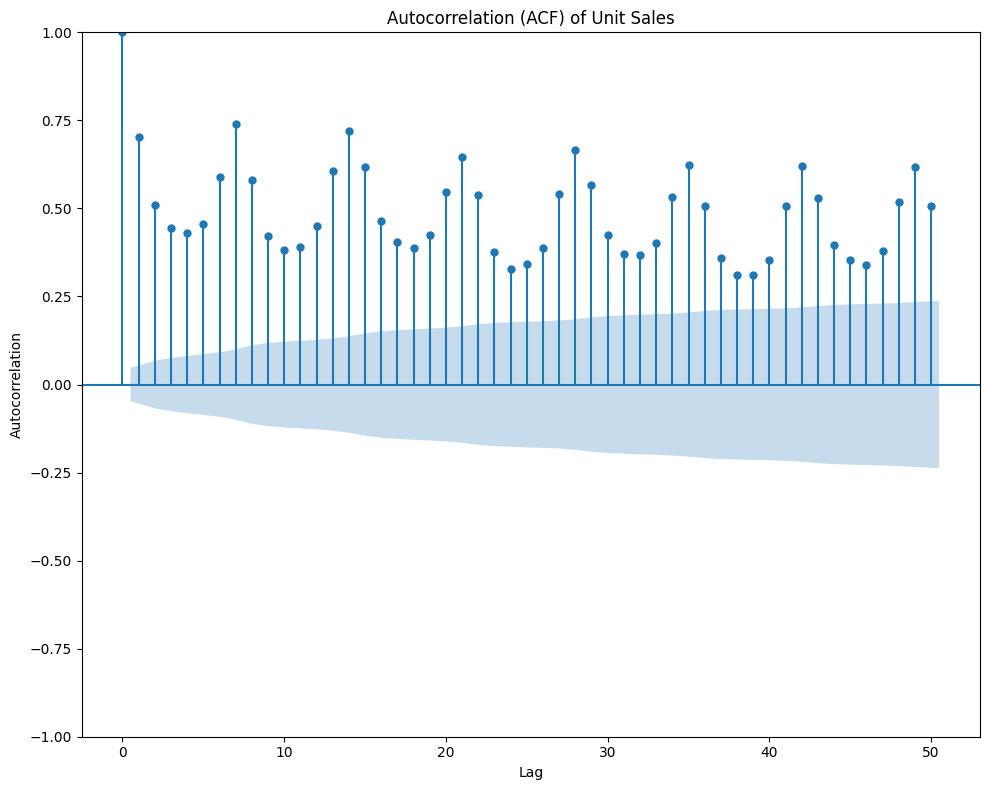

In [11]:

# Assume daily_sales is your time series and already preprocessed
plt.figure(figsize=(10, 5))
plot_acf(daily_sales.dropna(), lags=50)
plt.title('Autocorrelation (ACF) of Unit Sales')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()
#Using lags=50 is a practical default — it shows how  time series correlates with its past values up to 50 days back.

✅ Key Observations from the ACF Plot:
1.	**Strong autocorrelation at lag 1**
	•	Value close to 1 at lag 1 → very high similarity between today and yesterday’s sales.
	•	Suggests high temporal continuity.
2.	**Significant spikes at regular intervals**
	•	Many lags (e.g., 7, 14, 21…) have significant autocorrelation.
	•	This indicates weekly seasonality (which makes sense in retail due to shopping patterns).
3.	**All bars above blue shaded area**
	•	The blue region is the 95% confidence interval.
	•	Bars outside of it are statistically significant, not due to random noise.
	•	autocorrelations up to lag 50 are very strong — indicating non-stationarity.

### PAFC 

The PACF shows how much each lag individually contributes to the time series after removing the effects of earlier lags.

<Figure size 1000x500 with 0 Axes>

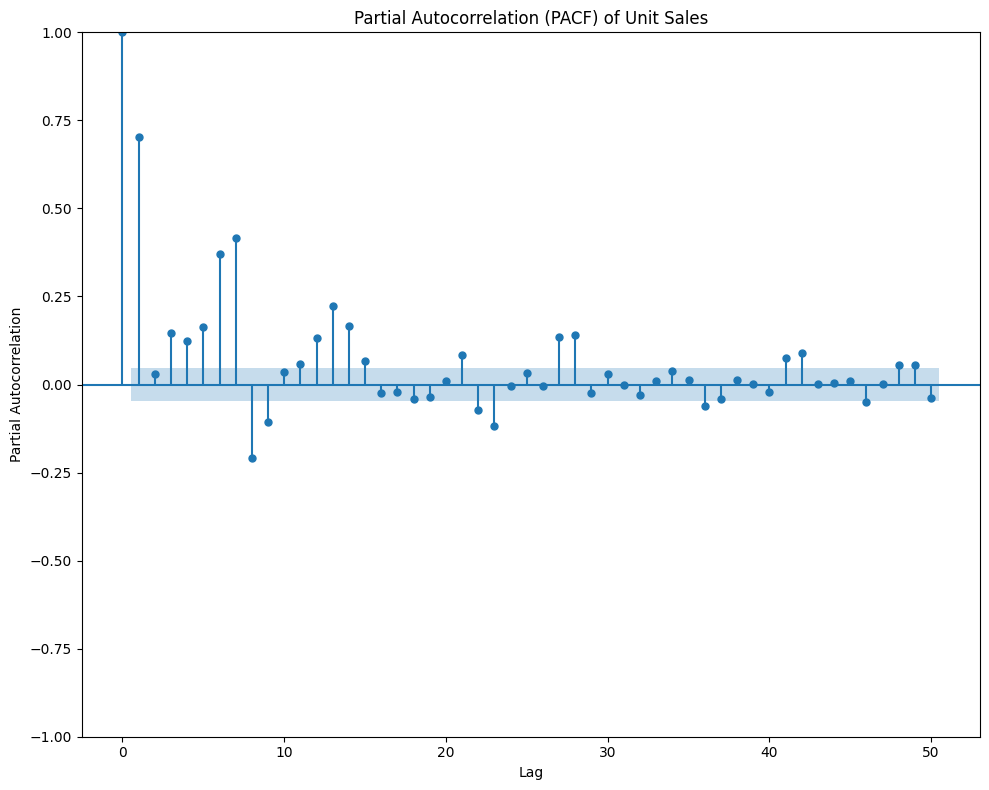

In [12]:

plt.figure(figsize=(10, 5))
plot_pacf(daily_sales.dropna(), lags=50, method='ywm')
plt.title('Partial Autocorrelation (PACF) of Unit Sales')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()

✅ Key Observations:
1.	**Strong spike at lag 1**
	•	Partial autocorrelation is very high at lag 1 → most of the series’ “memory” is captured by the first previous day.
	•	Suggests strong AR(1) behavior.
2.	**Significant spikes at lags 2–5 and some intermittent later lags**
	•	Indicates additional autoregressive effects beyond lag 1.
	•	But most values drop off quickly after lag ~7–10.
3.	**Lags beyond ~10 mostly stay within the blue confidence band**
	•	These are likely not statistically significant, i.e., they don’t add much unique explanatory power beyond the earlier lags.

✅ Which Lag Features to Create?

ACF and PACF plots suggest the following:

🔁 Short-term Lags (based on PACF):
	•	Strong autocorrelation up to lag 5–7
	•	These capture recent momentum or AR behavior

👉 Use: lag_1, lag_5, …, lag_7

🔁 Seasonal Lags (based on ACF):
	•	Regular spikes every 7 lags → indicates weekly seasonality

👉 Use: lag_7, lag_14, lag_21 (i.e., 1, 2, 3 weeks ago)

In [24]:
# Lag features (unit_sales)
df_train = df_train.sort_values(['store_nbr', 'item_nbr', 'date'])  # important for shifting

# Lag features (unit_sales)
for lag in [1, 7,14,30,60]:
    df_train[f'lag_{lag}'] = df_train.groupby (['store_nbr', 'item_nbr']) ['unit_sales'].shift(lag)

In [25]:
df_train.isnull().sum()

store_nbr              0
item_nbr               0
date                   0
id              20323588
unit_sales             0
onpromotion            0
outlier                0
dcoilwtico             0
transactions           0
is_holiday             0
is_event               0
lag_1              20788
lag_7             145516
lag_14            291032
lag_30            623640
lag_60           1247280
dtype: int64

## **3.Rolling Window / Exponential Moving Avg. Features (smoothing + trend detection)**

Rolling mean features help capture local trends, reduce noise, and provide the model with valuable temporal context, all of which improve the accuracy of sales forecasting models.A rolling window smooths the data by averaging (or summarizing) values over a fixed number of past days. Rolling Std means how much have unit sales varied over the past 7 days.

In [14]:
# Weekly seasonality (common in retail), sales pattern repeats every week, shift 1 to prevent data leakage
# Define rolling windows
windows = [7, 14, 30]

# Generate rolling features
for w in windows:
    df_train[f'rolling_mean_{w}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=w).mean())

    df_train[f'rolling_std_{w}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=w).std())
# Exponential moving average
# Define EWM spans (like 7-day, 14-day, 30-day)
spans = [7, 14, 30]

# Generate EWM features
for span in spans:
    df_train[f'ewm_mean_{span}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).ewm(span=span, adjust=False).mean())
    df_train[f'ewm_std_{span}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).ewm(span=span, adjust=False).std())

## **4.Promotion Effects**

onpromotion: (binary, 0 and 1), Now Create lagged promo indicators

In [15]:
df_train['promo_last_week'] = df_train.groupby(['store_nbr', 'item_nbr'])['onpromotion'].shift(7)

## **5.External Effects (Oil Price)**

dcoilwtico (oil price), which can be useful if: It impacts transportation costs or inventory planning

In [16]:
df_train['oil_price_lag_3'] = df_train['dcoilwtico'].shift(3)
df_train['oil_price_change'] = df_train['dcoilwtico'].pct_change()

## **6.Holiday/Event**

It helps the model learn “should we expect a sales jump tomorrow due to holiday or events?”

In [17]:
# Days until next holiday/event (basic flag shift)
df_train['next_is_holiday'] = df_train['is_holiday'].shift(-1).fillna(0).astype(int)
df_train['next_is_event'] = df_train['is_event'].shift(-1).fillna(0).astype(int)

## **7.Features from Transaction**

The transactions column in dataset is a valuable feature that represents customer foot traffic or activity per store per day. But its not given per item for each store number. Hence I am droping this column


In [18]:
df_train = df_train.drop(columns=['transactions'])

## **8. Convert Identifiers to Category**

In [19]:
# Convert identifiers to category
df_train['store_nbr'] = df_train['store_nbr'].astype('category')
df_train['item_nbr'] = df_train[ 'item_nbr'].astype('category')

## **9.Features from Outlier**

This tells the model: “Was there an outlier a day/week/month ago?”

In [20]:
# Lagged Outlier Flags
# These capture whether a recent outlier occurred — useful as a memory trigger:

#df_train = df_train.sort_values(['store_nbr', 'item_nbr', 'date'])

for lag in [1, 7, 14, 30]:
     df_train[f'outlier_lag_{lag}'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].shift(lag)

# Rolling Outlier Frequency
# This tracks how frequently outliers occurred in recent days (e.g., store-item has been unstable lately):
df_train['outlier_rolling_mean_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].transform(lambda x: x.shift(1).rolling(7).mean())


/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_20104/3332840895.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train[f'outlier_lag_{lag}'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].shift(lag)
/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_20104/3332840895.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train[f'outlier_lag_{lag}'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].shift(lag)
/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_20104/3332840895.py:7: FutureWarning: The default of observed=False is deprecated and will be changed t

In [23]:
df_train.shape

(35069356, 46)

In [ ]:
#df_train.to_csv('feature_eng.csv', index=False)

# **Filtering Dataset upto 31-03-2014**

In [22]:
max_date='2014-04-01'
df_train=df_train[df_train['date'] < max_date]


In [23]:
print(df_train['date'].min())
print(df_train['date'].max())
print(df_train.shape)

2013-01-02 00:00:00
2014-03-31 00:00:00
(9437752, 44)


In [ ]:
#df_train.to_csv('feature_eng_upto_2014.csv', index=False)

In [4]:
# setting the file path - locally.
file_path = './data_store_sales/'
# Load the merged files into pandas DataFrames
df_train_filtered= pd.read_csv(file_path+'feature_eng_upto_2014.csv')

In [26]:
df_train_filtered.head(10)

,store_nbr,item_nbr,date,unit_sales,onpromotion,outlier,dcoilwtico,is_holiday,is_event,dayofweek,...,promo_last_week,oil_price_lag_3,oil_price_change,next_is_holiday,next_is_event,outlier_lag_1,outlier_lag_7,outlier_lag_14,outlier_lag_30,outlier_rolling_mean_7
0,24,96995,2013-01-02,0.0,0,0,93.140000,0,0,2,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN
1,24,96995,2013-01-03,0.0,0,0,92.970000,0,0,3,...,NaN,NaN,-0.001825,0,0,0.0,NaN,NaN,NaN,NaN
2,24,96995,2013-01-04,0.0,0,0,93.120000,0,0,4,...,NaN,NaN,0.001613,0,0,0.0,NaN,NaN,NaN,NaN
3,24,96995,2013-01-05,0.0,0,0,93.146667,0,0,5,...,NaN,93.140000,0.000286,0,0,0.0,NaN,NaN,NaN,NaN
4,24,96995,2013-01-06,0.0,0,0,93.173333,0,0,6,...,NaN,92.970000,0.000286,0,0,0.0,NaN,NaN,NaN,NaN
5,24,96995,2013-01-07,0.0,0,0,93.200000,0,0,0,...,NaN,93.120000,0.000286,0,0,0.0,NaN,NaN,NaN,NaN
6,24,96995,2013-01-08,0.0,0,0,93.210000,0,0,1,...,NaN,93.146667,0.000107,0,0,0.0,NaN,NaN,NaN,NaN
7,24,96995,2013-01-09,2.0,0,0,93.080000,0,0,2,...,0.0,93.173333,-0.001395,0,0,0.0,0.0,NaN,NaN,0.0
8,24,96995,2013-01-10,0.0,0,0,93.810000,0,0,3,...,0.0,93.200000,0.007843,0,0,0.0,0.0,NaN,NaN,0.0
9,24,96995,2013-01-11,0.0,0,0,93.600000,0,0,4,...,0.0,93.210000,-0.002239,0,0,0.0,0.0,NaN,NaN,0.0


In [27]:
df_train_filtered.columns

Index(['store_nbr', 'item_nbr', 'date', 'unit_sales', 'onpromotion', 'outlier',
       'dcoilwtico', 'is_holiday', 'is_event', 'dayofweek', 'is_weekend',
       'month', 'day', 'weekofyear', 'year', 'is_month_start', 'is_month_end',
       'lag_1', 'lag_7', 'lag_14', 'lag_30', 'lag_60', 'rolling_mean_7',
       'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30',
       'rolling_std_30', 'ewm_mean_7', 'ewm_std_7', 'ewm_mean_14',
       'ewm_std_14', 'ewm_mean_30', 'ewm_std_30', 'promo_last_week',
       'oil_price_lag_3', 'oil_price_change', 'next_is_holiday',
       'next_is_event', 'outlier_lag_1', 'outlier_lag_7', 'outlier_lag_14',
       'outlier_lag_30', 'outlier_rolling_mean_7'],
      dtype='object')

In [28]:
df_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437752 entries, 0 to 9437751
Data columns (total 44 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   store_nbr               int64  
 1   item_nbr                int64  
 2   date                    object 
 3   unit_sales              float64
 4   onpromotion             int64  
 5   outlier                 int64  
 6   dcoilwtico              float64
 7   is_holiday              int64  
 8   is_event                int64  
 9   dayofweek               int64  
 10  is_weekend              int64  
 11  month                   int64  
 12  day                     int64  
 13  weekofyear              int64  
 14  year                    int64  
 15  is_month_start          int64  
 16  is_month_end            int64  
 17  lag_1                   float64
 18  lag_7                   float64
 19  lag_14                  float64
 20  lag_30                  float64
 21  lag_60                  float64

In [29]:
df_train_filtered.isnull().sum()

store_nbr                       0
item_nbr                        0
date                            0
unit_sales                      0
onpromotion                     0
outlier                         0
dcoilwtico                      0
is_holiday                      0
is_event                        0
dayofweek                       0
is_weekend                      0
month                           0
day                             0
weekofyear                      0
year                            0
is_month_start                  0
is_month_end                    0
lag_1                       20788
lag_7                      145516
lag_14                     291032
lag_30                     623640
lag_60                    1247280
rolling_mean_7             145516
rolling_std_7              145516
rolling_mean_14            291032
rolling_std_14             291032
rolling_mean_30            623640
rolling_std_30             623640
ewm_mean_7                  20788
ewm_std_7     

In [30]:
df_train_filtered['unit_sales'].describe() 

count    9.437752e+06
mean     2.070799e+00
std      8.254941e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.935000e+03
Name: unit_sales, dtype: float64

# **Model (SARIMAX)**

Auto Regressive Integrated Moving Average **(ARIMA)** with Seasonal effect is called **SARIMA**. **SARIMA** with exogenous variable or external factors called **SARIMAX**, which  is not meant for multi-series forecasting (like LightGBM/XGBoost).
So I’d apply SARIMAX to just one series — for example:

I am doing, Forecast for unit_sales for store_nbr = 24 and item_nbr = 96995.

✅ SARIMAX Evaluation (Test Set):
📉 MSE  : 4.09
📉 RMSE : 2.02
📉 MAPE : 48.78%
📈 R²   : 0.0114


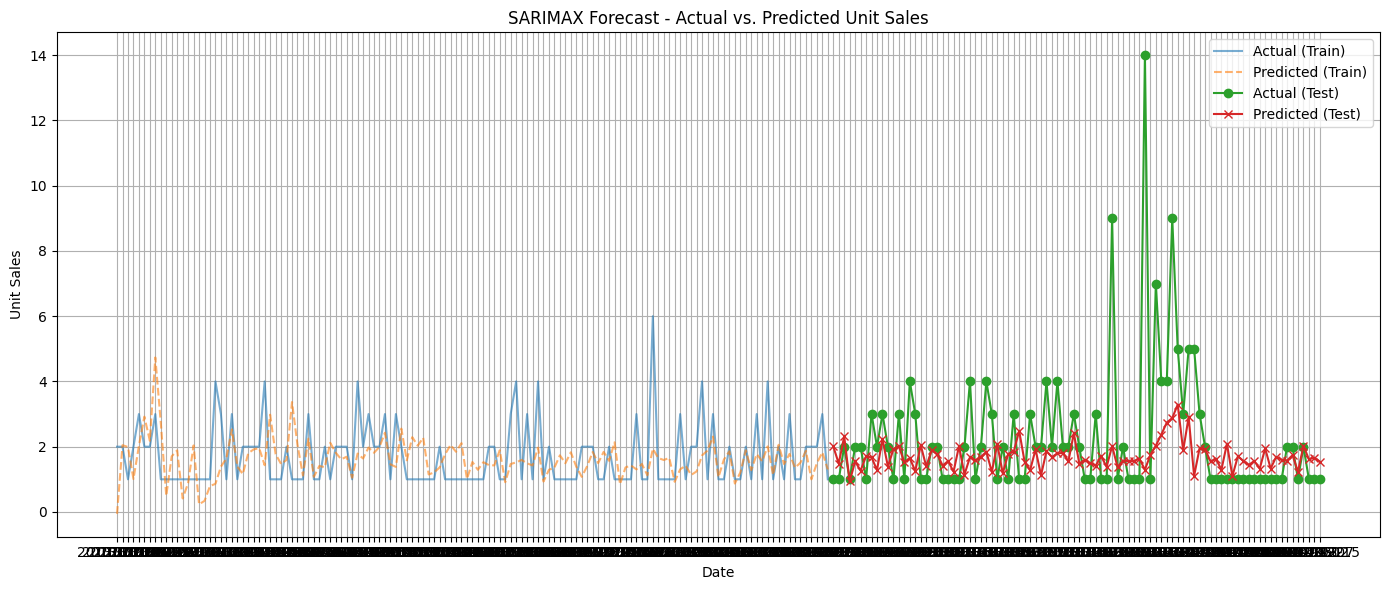

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Step 1: Filter data for one store-item and non-zero unit_sales
df_single = df_train_filtered[(df_train_filtered['store_nbr'] == 24) & (df_train_filtered['item_nbr'] == 96995)].copy()
df_single = df_single[df_single['unit_sales'] > 0].sort_values('date')
df_single.set_index('date', inplace=True)

# Step 2: Select numeric exogenous variables (exclude ID/date/target)
#exclude_cols = ['store_nbr', 'item_nbr', 'unit_sales','year','month','weekofyear','day','rolling_std_30','ewm_std_30']
#exog_vars = [col for col in df_single.select_dtypes(include=['number']).columns if col not in exclude_cols]

# Step 2.5: Plot correlation of all exog features with unit_sales
#correlation_df = df_single[['unit_sales'] + exog_vars].dropna()
#corr = correlation_df.corr()['unit_sales'].drop('unit_sales').sort_values(key=abs, ascending=False)

# Plot
#plt.figure(figsize=(8, len(corr) * 0.3 + 2))
#corr.plot(kind='barh', color='teal')
#plt.title("Correlation of Features with Unit Sales")
#plt.xlabel("Correlation Coefficient")
#plt.grid(True)
#plt.tight_layout()
#plt.show()

# Step 2.6: Filter exog_vars by correlation threshold (≥ 0.10 recommended)
#correlations = correlation_df.corr()['unit_sales'].drop('unit_sales')
#exog_vars = correlations[correlations.abs() >= 0.10].index.tolist()

#print("✅ Filtered exog_vars based on correlation >= 0.10:")
#print(exog_vars)
exog_vars=['lag_1', 'lag_7','rolling_mean_7', 'ewm_mean_7','outlier', 'is_holiday','outlier_rolling_mean_7', 'next_is_holiday','is_month_start','is_month_end']

# Step 3: Drop any rows with NaNs in target or selected exog_vars
df_single = df_single.dropna(subset=['unit_sales'] + exog_vars)

# Step 4: Train/test split (last 90 days)
train = df_single.iloc[:-90]
test = df_single.iloc[-90:]

# Step 5: Extract y and X, then scale X and log-transform y
y_train = np.log1p(train['unit_sales'])
y_test = np.log1p(test['unit_sales'])

X_train_raw = train[exog_vars]
X_test_raw = test[exog_vars]

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), index=X_train_raw.index, columns=X_train_raw.columns)
X_test = pd.DataFrame(scaler.transform(X_test_raw), index=X_test_raw.index, columns=X_test_raw.columns)

# Step 6: Fit SARIMAX model
model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 1, 1), # order (p-AR, d-diff, q-MR)
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

# Step 7: Predict for both train and test
y_train_pred_log = results.predict(start=0, end=len(y_train) - 1, exog=X_train)
y_test_pred_log = results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# clip predictions to safe logscale range
y_test_pred_log = np.clip(y_test_pred_log, a_min=-5, a_max=5)
y_train_pred_log = np.clip(y_train_pred_log, a_min=-5, a_max=5)

# Inverse transform to get original scale
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

# Step 8: Evaluation on test set
mse = mean_squared_error(y_test_actual, y_test_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)
r2 = r2_score(y_test_actual, y_test_pred)

print("✅ SARIMAX Evaluation (Test Set):")
print(f"📉 MSE  : {mse:.2f}")
print(f"📉 RMSE : {rmse:.2f}")
print(f"📉 MAPE : {mape:.2%}")
print(f"📈 R²   : {r2:.4f}")

# Step 9: Plot actual vs. prediction (train + test)
plt.figure(figsize=(14, 6))
plt.plot(y_train_actual.index, y_train_actual, label='Actual (Train)', alpha=0.6)
plt.plot(y_train_actual.index, y_train_pred, label='Predicted (Train)', linestyle='--', alpha=0.6)
plt.plot(y_test_actual.index, y_test_actual, label='Actual (Test)', marker='o')
plt.plot(y_test_actual.index, y_test_pred, label='Predicted (Test)', marker='x')

plt.title("SARIMAX Forecast - Actual vs. Predicted Unit Sales")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Tripple Exponential Smoothing (Holt Winter Model)**

2014-03-31 00:00:00
2013-01-02 00:00:00
   store_nbr  item_nbr       date  unit_sales  onpromotion  outlier  \
0         24     96995 2013-01-02         0.0            0        0   
1         24     96995 2013-01-03         0.0            0        0   
2         24     96995 2013-01-04         0.0            0        0   
3         24     96995 2013-01-05         0.0            0        0   
4         24     96995 2013-01-06         0.0            0        0   

   dcoilwtico  is_holiday  is_event  dayofweek  ...  promo_last_week  \
0   93.140000           0         0          2  ...              NaN   
1   92.970000           0         0          3  ...              NaN   
2   93.120000           0         0          4  ...              NaN   
3   93.146667           0         0          5  ...              NaN   
4   93.173333           0         0          6  ...              NaN   

   oil_price_lag_3  oil_price_change  next_is_holiday  next_is_event  \
0              NaN          

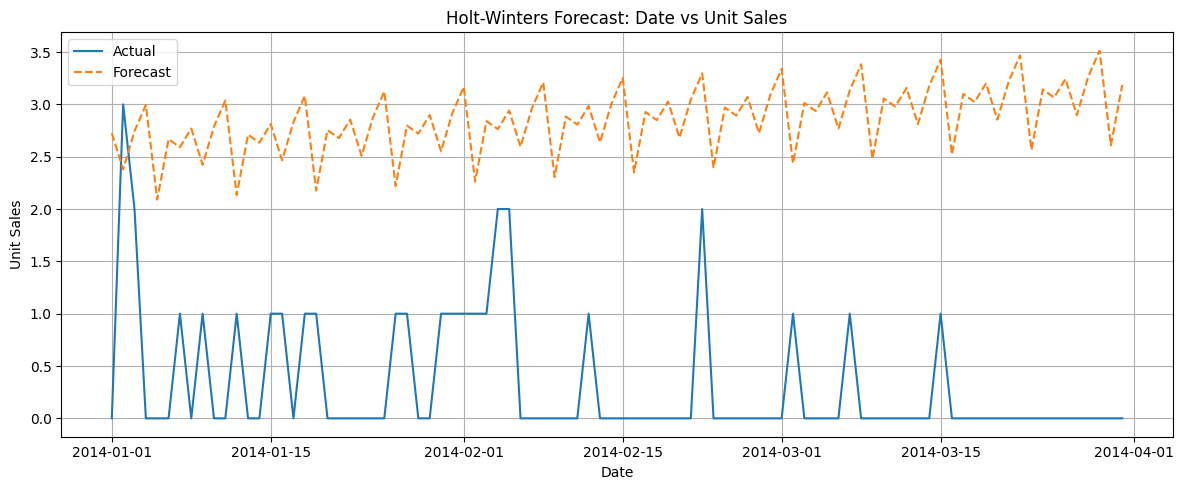

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt



# Filter for specific store and item
filtered_df = df_train_filtered[(df_train_filtered['store_nbr'] == 24) & (df_train_filtered['item_nbr'] == 96995)].copy()
#filtered_df = filtered_df[filtered_df['unit_sales'] > 0]

# Ensure date is datetime and sorted
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
print(filtered_df['date'].max())
print(filtered_df['date'].min())
print(filtered_df.head(5))

# Ensure date is datetime and sorted
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
filtered_df.sort_values('date', inplace=True)
# Set date as index
ts = filtered_df.set_index('date')['unit_sales']
print(ts.head(8))
# Train/test split (last 90 days as test)
train_ts = ts[:-90]
test_ts = ts[-90:]
# Fit Holt-Winters model
model = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=7)
fit = model.fit()

# Forecast
forecast = fit.forecast(len(test_ts))

# Evaluation
rmse = np.sqrt(mean_squared_error(test_ts, forecast))
mae = mean_absolute_error(test_ts, forecast)
r2 = r2_score(test_ts, forecast)

# Print metrics
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R2 Score: {r2:.2f}')

# Plot
plt.figure(figsize=(12, 5))
plt.plot(test_ts.index, test_ts.values, label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast', linestyle='--')
plt.title("Holt-Winters Forecast: Date vs Unit Sales")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
print("Log-scale test predictions (sample):")
print(y_test_pred_log.describe())

Log-scale test predictions (sample):
count    90.000000
mean     13.676160
std      22.725970
min     -10.639421
25%       1.031565
50%       1.677736
75%      35.004155
max      56.808078
Name: predicted_mean, dtype: float64


Model is not able to predict the forecast. Lets cut off the features that are very weakly correlated to target value 'Unit_Sales'. Then, will apply Standard Scaler to X_train  and X_test. And finally,  apply log transformation to y_train and y_test. SARIMAX wont handle zero values well, so need to filter that out.

SARIMAX is not working well for this item.
It’s overfitting or underfitting due to sparse, low-count unit sales and weak seasonal signals.
Now will switch to  XGBoost or LightGBM (Tree-based models handle zeros, spikes, non-linear patterns well
)
